# Analytics Assignment

Let's peek at the data.

In [1087]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [1088]:
df = pd.read_csv('traffic_sample.csv')
df['_timestamp'] = pd.to_datetime(df['_timestamp'].str.replace(' UTC', '' ), format='%Y-%m-%d %H:%M:%S.%f')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877420 entries, 0 to 4877419
Data columns (total 7 columns):
_timestamp       datetime64[ns]
asn              object
ip               object
account          object
user_agent       object
fingerprint      object
is_successful    int64
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 260.5+ MB


* **_timestamp** - the date and time of the attempted login
* **asn** - the unique name of the system that attempted the login
* **ip** - the IP address of the machine that attempted the login
* **account** - the username used during the attempted login
* **user_agent** - the browser used during the attempted login
* **fingerprint** - the fingerprint of the attempted login
* **is_successful** - boolean indicating if the attempted login was successful

In [1089]:
df.head()

,_timestamp,asn,ip,account,user_agent,fingerprint,is_successful
0,2019-02-26 23:59:53.795,Boar,4ed5.131.12.161,9jl+ubSARg,9f0a657d28,a6aa7e0552,0
1,2019-02-26 23:59:56.681,Blacktip Reef Shark,4ed5.89.55.222,tE9q8BwFG8,9f0a657d28,a6aa7e0552,0
2,2019-02-26 23:58:47.484,Caribou,12cf.87.176.70,H6vaD/O2rr,9f0a657d28,a6aa7e0552,0
3,2019-02-26 23:59:07.429,Bearded Dragon,fc4e.222.152.73,VQZMh1bCq8,9f0a657d28,a6aa7e0552,0
4,2019-02-26 23:59:47.459,Bird,21a8.113.225.114,yDSiAT2D82,9f0a657d28,a6aa7e0552,0


First, let's try to label some of the more egregious bot traffic.

If a username is being used to log in across a large number of IP addresses, it most likely means the username has been stolen, and if a device is attempting to log in with a stolen username, it is most likely a bot.

Let's figure out which usernames have been stolen.

In [1090]:
df.groupby('account').agg({'ip':'nunique', 'asn':'nunique', 'user_agent':'nunique', 'fingerprint':'nunique', 'account':'count', 'is_successful':'sum', '_timestamp':'min'}).rename(columns={'ip':'unique_ip_count', 'asn':'unique_asn_count', 'user_agent':'unique_user_agent_count', 'fingerprint':'unique_fingerprint_count', 'account':'login_attempt_count', 'is_successful':'login_success_count', '_timestamp':'traffic_started_on'}).sort_values('unique_ip_count', ascending=False).head(5)

,unique_ip_count,unique_asn_count,unique_user_agent_count,unique_fingerprint_count,login_attempt_count,login_success_count,traffic_started_on
account,,,,,,,
47DEQpj8HB,920945,55,563,8,1820355,1812565,2019-02-25 00:00:00.090
H4zXlbnMEA,385676,56,5332,9,660241,610458,2019-02-25 00:00:00.356
MCdjQmonCz,9165,25,1895,1,11493,10678,2019-02-25 00:00:05.704
NygkDML5IM,4082,21,1064,1,4887,4572,2019-02-25 00:00:08.775
ZzFgMH1SU+,3745,23,958,1,4512,4228,2019-02-25 00:01:35.740


This looks...questionable. Could a single username really have been used by **1 million** different devices with such a high log in success rate? The instructions indicate that the values in the account column are just **extracts** of the full hash, so username '47DEQpj8HB' most likely represents **many** unique usernames. So much for that.

Per tip #3 from our colleague, we should be able to label IP addresses that use large numbers of usernames *unsuccessfully* as bots.

In [1091]:
ips = df.groupby('ip').agg({'account':'nunique', 'is_successful':'sum', 'ip':'count'}).rename(columns={'account':'unique_account_count', 'ip':'login_attempt_count', 'is_successful':'login_success_count'}).sort_values('unique_account_count', ascending=False)
ips['login_success_rate'] = ips.login_success_count / ips.login_attempt_count
ips.drop(['login_success_count', 'login_attempt_count'], axis=1, inplace=True)
ips['is_bot'] = (ips.unique_account_count >= 5.0) & (ips.login_success_rate <= 0.1)
df = pd.merge(df, ips[ips['is_bot'] == 1].is_bot, on='ip', how='left')
df.is_bot.fillna(False, inplace=True)

In [1092]:
df.is_bot.value_counts()

False    4397824
True      479596
Name: is_bot, dtype: int64

Let's see if this traffic follows a non-diurnal pattern per tip #1.

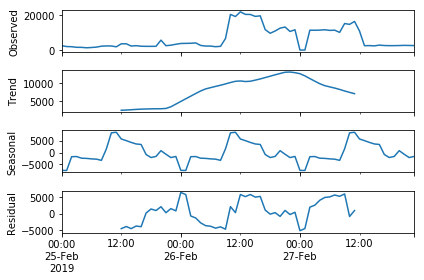

In [1093]:
df.set_index(df['_timestamp'].dt.floor('h'), inplace=True)
result = seasonal_decompose(df[df['is_bot'] == True].index.value_counts().sort_index().asfreq('H', fill_value=0), model='additive')
result.plot()
plt.show()

Two hours of data are missing from 12am-1am on Feb 27, but even without, this as a suspicious pattern. Let's look at the traffic we have inversely identified as human.

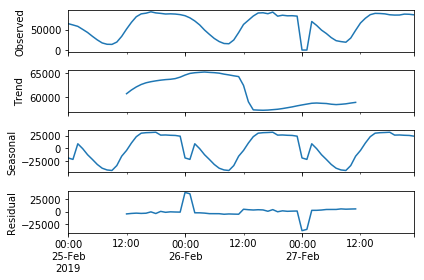

In [1094]:
result = seasonal_decompose(df[df['is_bot'] == False].index.value_counts().sort_index().asfreq('H', fill_value=0), model='additive')
result.plot()
plt.show()

Despite the two missing ours, this is a diurnal pattern, so we're on the right track.

Tip #3 says that botnets use limited IP ranges. Let's get the login success rate by IP range.

In [1095]:
df['ip_range'] = df['ip'].str.replace(r'\.\d+$', '')
ip_ranges = df.groupby('ip_range').agg({'ip':'nunique', 'account':'count', 'is_successful':'sum'}).rename(columns={'ip':'unique_ip_count', 'account':'login_attempt_count', 'is_successful':'login_success_count'}).sort_values('login_attempt_count', ascending=False)
ip_ranges['login_success_rate'] = ip_ranges.login_success_count / ip_ranges.login_attempt_count
ip_ranges.head()

,unique_ip_count,login_attempt_count,login_success_count,login_success_rate
ip_range,,,,
2606.58.21,256,45150,42117,0.932824
2606.58.12,256,28100,26089,0.928434
1466.171.81,94,26662,1,0.000038
708a.77.245,12,25421,22564,0.887613
2606.58.23,130,22713,21237,0.935015


In [1096]:
ip_ranges['is_bot'] = (ip_ranges.login_attempt_count >= 5) & (ip_ranges.login_success_rate <= 0.1)
df = pd.merge(df, ip_ranges[ip_ranges['is_bot'] == 1].is_bot, on='ip_range', how='left')
df['is_bot'] = df.is_bot_x | df.is_bot_y
df.drop(['is_bot_x', 'is_bot_y'], axis=1, inplace=True)
df.is_bot.value_counts()

False    4360310
True      517110
Name: is_bot, dtype: int64

Added about 30K labels! Nice!

Let's start fulfilling the requirements of the assignment now. We'll skip #1 until we've engineered all the features for our model.

## 2. A visualization of the traffic sample.

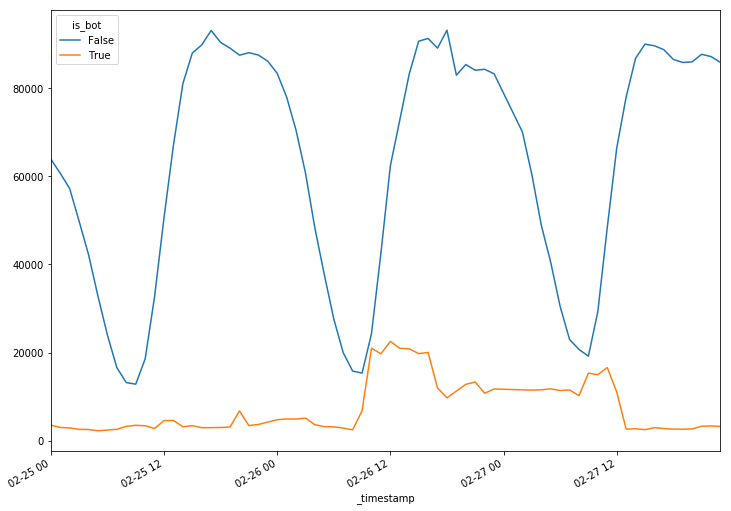

In [1097]:
df.groupby([df['_timestamp'].dt.floor('h'),'is_bot']).count()['ip'].unstack().plot(subplots=False, figsize=(12, 9))

## 3a. What percentage of the traffic sample is automated traffic?

In [1098]:
df.is_bot.value_counts(normalize=True)

False    0.893979
True     0.106021
Name: is_bot, dtype: float64

## 3b. What is the login success rate (i) Overall (ii) For human traffic (iii) For automated traffic

(i) Overall

In [1099]:
logins = df.agg({'ip':'count', 'is_successful':'sum'}).rename(columns={'ip':'login_attempt_count', 'is_successful':'login_success_count'})
logins.loc['is_successful'] / logins.loc['ip']



0.8310805712856387

(ii) For human traffic

In [1100]:
logins = df[df.is_bot == False].agg({'ip':'count', 'is_successful':'sum'}).rename(columns={'ip':'login_attempt_count', 'is_successful':'login_success_count'})
logins.loc['is_successful'] / logins.loc['ip']



0.9294123582956257

(iii) For automated traffic

In [1101]:
logins = df[df.is_bot == True].agg({'ip':'count', 'is_successful':'sum'}).rename(columns={'ip':'login_attempt_count', 'is_successful':'login_success_count'})
logins.loc['is_successful'] / logins.loc['ip']

0.001939625998336911

## 3c. What are the top (i) ASNs (ii) Fingerprints (iii) User agents for automated traffic?

(i) ASNS

In [1102]:
df[df.is_bot == True].groupby('asn').count().sort_values('ip', ascending=False)['ip']

asn
Aardvark                 182031
Aardwolf                  85097
Anteater                  27085
Antelope                  20785
Aye-Aye                   10311
Bandicoot                  8724
African Tree Pangolin      8641
Anthropod                  7929
Bearded Dragon             7718
Bat                        7645
Beluga Whale               7116
Bangle Tiger               6967
Ape                        6837
Billy Goat                 6639
Bird                       5921
Bison                      5692
Asian Elephant             5353
Black Rhino                5158
Blue Whale                 4923
Black Howler Monkey        4847
Black Footed Rhino         4716
Bobcat                     4555
Blacktip Reef Shark        4366
Bengal Tiger               4199
Brown Bear                 4072
                          ...  
Cattle                     2860
Caribou                    2779
Common Dolphin             2735
Common Seal                2599
Black Bear                 2526
Beav

(ii) Fingerprints

In [1103]:
df[df.is_bot == True].groupby('fingerprint').count().sort_values('ip', ascending=False)['ip']

fingerprint
f672c6ea9c    293700
b747f0cc00     99742
a6aa7e0552     84368
bb8c1fc381     33614
f6c6dae97c      1856
56e485800a      1765
ebc1e6a4f8       678
5a6044dc6c       635
c66d7ff0ea       403
245f996195       186
57963cd951       113
da7fcce28f        18
d93a4d7463         9
d9888e2175         6
7f7d9648bd         5
5688ce594b         5
9c0f6f6b2a         4
e4ab0181b9         3
Name: ip, dtype: int64

(iii) User agents

In [1104]:
df[df.is_bot == True].groupby('user_agent').count().sort_values('ip', ascending=False)['ip']

user_agent
9f0a657d28    84988
c3de0d9a7c      415
7e57ff0758       80
8b1aba0808       37
cba4767ccc       36
cb1d377cf7       36
3bfa188e99       36
8b457a5e50       35
e0c6f26634       35
376e88d9a3       35
d455b9ccad       35
b4ffc05020       35
2bfa0fc8ee       34
a2bbdf558e       34
26f8c93632       34
6b3cc6fd09       33
4620e23beb       33
68a8291023       33
00b785af0a       33
f40d25b96b       32
c75e649b26       32
e44fa0ef90       32
ef80a5e774       32
0a2334e7f7       32
39b38a9c57       32
              ...  
660581aed9        1
6604be1371        1
66038f396c        1
660340b3fa        1
6602b70221        1
6601f92618        1
660192e06c        1
660083520a        1
65fe886bcd        1
65fd33123f        1
65fb9fa531        1
65f2922be7        1
65fb6452d9        1
65fa752b0d        1
65f7f37fd3        1
65f7d51781        1
65f72c604b        1
65f72c09a4        1
65f6b921bd        1
65f67ca224        1
65f6733c4c        1
65f5aaa8f3        1
65f3fdc67e        1
65f2bed90

## Let's engineer features for our model

1. Automated traffic follows a non-diurnal pattern

As we have seen, automated traffic is more spread out across the day than its human counterpart because humans sleep and bots do not. To capture the degree to which traffic varies throughout the day, we will calculate the hourly variance.

First, we need to extract the hour from the timestamp.

In [1105]:
df['hour'] = df._timestamp.dt.hour

Now we need to encode our new hour feature to reflect its cyclical nature. If we leave it as is, the variance calculation won't be accurate. The difference between midnight (0) and 11pm (23) isn't 23, it's 1! 

In [1106]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df = encode(df, 'hour', 24)
df[(df['hour'] == 0) | (df['hour'] == 23)].groupby('hour').agg({'hour_sin': 'max','hour_cos': 'max'})

,hour_sin,hour_cos
hour,,
0,0.000000,1.000000
23,-0.258819,0.965926


Our hour values are now represented by pairs of coordinates on a circle. The values for midnight (0) and 11pm (23) are now very close to each other in magnitude. Now we can calculate the variance.

In [1107]:
train_df = df.groupby('ip').agg({'is_bot': 'max', 'hour_sin': 'var', 'hour_cos': 'var'}).fillna(0.0)
train_df.head()


,is_bot,hour_sin,hour_cos
ip,,,
0222.110.101.9,True,0.571889,0.412448
0222.110.123.127,False,0.011455,0.338916
0222.110.144.37,False,0.004990,0.029084
0222.110.19.200,False,0.000000,0.000000
0222.110.51.241,True,0.532500,0.334137


Let's peek at a couple of these and see if they validate our assumptions. Higher values in the variance columns should correlate with non-diurnal login patterns.

High (0.571889, 0.412448)

In [1108]:
df[df['ip'] == '0222.110.101.9']['hour'].value_counts().sort_index()

1     2
2     2
5     2
6     1
7     1
8     2
13    1
16    1
17    1
19    1
22    1
Name: hour, dtype: int64

Low (0.011455, 0.338916)

In [1109]:
df[df['ip'] == '0222.110.123.127']['hour'].value_counts().sort_index()

15    1
16    1
19    1
20    1
Name: hour, dtype: int64

Success! Let's move on to the next feature.

## 2. Automated traffic volume has low variance over time

The volume of automated traffic tends to remain constant between the time it starts and the time it ends. Human traffic varies much more. A good metric for measuring this is the variance of the time between login attempts. Automated traffic should exhibit lower variance than human traffic.

$$𝑟𝑡=Δln𝑦𝑡≡ln𝑦𝑡−ln𝑦𝑡−1.$$


In [1110]:
#df_count = df.groupby(['ip', 'timestamp_hour']).ip.agg('count').to_frame('login_count').reset_index()[['ip', 'timestamp_hour', 'login_count']].sort_values(['ip', 'timestamp_hour'], ascending=True)
df['prev_ip'] = df.sort_values(['ip', '_timestamp'], ascending=True)['ip'].shift(1)
df['prev_timestamp'] = df.sort_values(['ip', '_timestamp'], ascending=True)['_timestamp'].shift(1)
df['timestamp_delta_var'] = (df[df['ip'] == df['prev_ip']]['_timestamp'] - df['prev_timestamp']).astype('timedelta64[s]')
train_df = pd.merge(train_df, df.groupby('ip').timestamp_delta_var.var().fillna(0), on='ip', how='left')
#df.groupby('ip').timestamp_delta.var().fillna(100)
#df[df['ip'] =='0222.110.101.9']

#df_count['login_count-1'] = df_count.login_count.shift(1).fillna(0)
#df_count['login_count_delta'] = (df_count[df_count['ip'] == df_count['ip-1']]['login_count'] - df_count[df_count['ip'] == df_count['ip-1']]['login_count-1']) / df_count[df_count['ip'] == df_count['ip-1']]['login_count-1']
#df_count['login_count_delta'].fillna(0, inplace=True)
#df_count[df_count['ip'] == 'fc4e.224.35.165']
#df_count = df_count.groupby('ip').login_count_delta.agg('var').fillna(0)
#df_count

## 3, 4 and 5. Automated traffic has: 1) High login volumes 2) High username volumes and 3) High rates of failure

In [1111]:
#1) High login volumes
train_df = pd.merge(train_df, df.groupby(['ip']).size().to_frame('login_attempt_count'), on='ip', how='left')

#2) High credential volumes
train_df = pd.merge(train_df, df.groupby(['ip'])['account'].nunique().to_frame('unique_username_count'), on='ip', how='left')

#3) High failure rates
train_df = pd.merge(train_df, df.groupby(['ip']).is_successful.sum().to_frame('login_success_count'), on='ip', how='left')

train_df['login_success_rate'] = train_df.login_success_count / train_df.login_attempt_count


In [1112]:
train_df.head()

,is_bot,hour_sin,hour_cos,timestamp_delta_var,login_attempt_count,unique_username_count,login_success_count,login_success_rate
ip,,,,,,,,
0222.110.101.9,True,0.571889,0.412448,1.643726e+08,15,15,0,0.0
0222.110.123.127,False,0.011455,0.338916,3.146537e+07,4,4,0,0.0
0222.110.144.37,False,0.004990,0.029084,0.000000e+00,2,2,0,0.0
0222.110.19.200,False,0.000000,0.000000,0.000000e+00,1,1,0,0.0
0222.110.51.241,True,0.532500,0.334137,6.852461e+07,23,23,0,0.0


In [1113]:
Time to train and test the model.

SyntaxError: invalid syntax (<ipython-input-1113-c69f30026b9f>, line 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop('is_bot', axis=1), train_df.is_bot, test_size=0.2, random_state=1337, stratify=train_df.is_bot)


In [ ]:
clf = LogisticRegression(C=1.0,
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class=u'ovr', n_jobs=None, penalty='l2',
          random_state=1337, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
predictions = clf.predict(x_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)
score = clf.score(x_test, y_test)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## 1. A list of signatures for the automated traffic.

In [ ]:
train_df.drop('is_bot', axis=1).dtypes

In [ ]:
#pd.set_option('display.max_rows', 50)
#train_df.to_csv(path_or_buf='/Users/sthomas/Shape Security/training_data.csv', index=True)